In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pysindy as ps
from math import pi
from pde import PDE, CartesianGrid, MemoryStorage, ScalarField

In [30]:
def plot_solution(x, t, u, main_str):
    plt.figure()
    plt.pcolormesh(x, t, u)
    plt.xlabel('x', fontsize=16)
    plt.ylabel('t', fontsize=16)
    plt.title(main_str, fontsize=16)
    plt.colorbar()

In [43]:
a = 0.8   # diffusivity (scales time)
equation = PDE({"u": f"{a} * laplace(u)"},
                # bc={"value": "cos(x)"}
                )

x_min = -pi
x_max = pi
x_num_elements = 64

grid = CartesianGrid([[x_min, x_max]], [x_num_elements], periodic=True)
state = ScalarField.from_expression(grid, "cos(x)")

t_max = 3
t_num_elements = 64

storage = MemoryStorage()
result = equation.solve(state, t_range=t_max, tracker=storage.tracker(t_max/t_num_elements))

x = np.ravel(storage.grid.axes_coords)
t = np.ravel(storage.times)
u = np.real(storage.data)

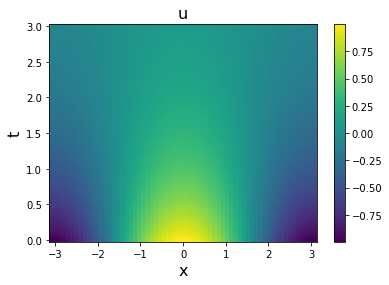

In [44]:
plot_solution(x, t, u, "u")

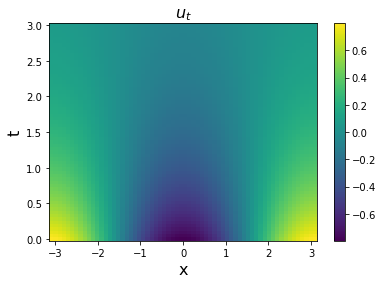

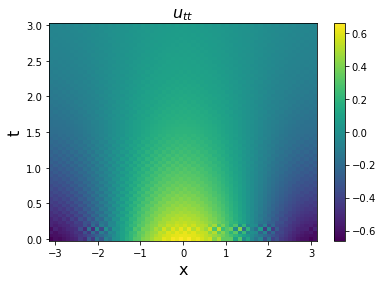

In [45]:
dt = t[1] - t[0]
for i in range(1, 3):
    u_i = ps.FiniteDifference(d=i, axis=0)._differentiate(u, t=dt)
    plot_solution(x, t, u_i, "$u_{{{}}}$".format("t"*i))


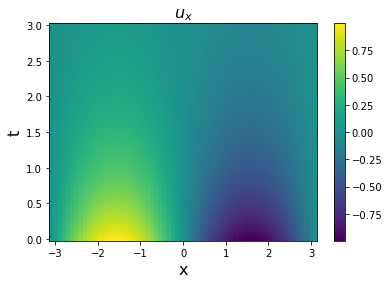

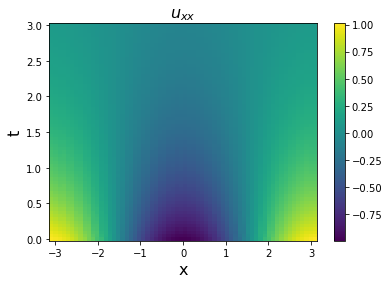

In [46]:
dx = x[1] - x[0]
for i in range(1, 3):
    u_i = ps.SmoothedFiniteDifference(d=i, axis=1)._differentiate(u, t=dx)
    plot_solution(x, t, u_i, "$u_{{{}}}$".format("x"*i))

In [47]:
u = u.reshape(len(t), len(x), 1)

library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]
pde_lib = ps.PDELibrary(library_functions=library_functions, 
                        function_names=library_function_names, 
                        derivative_order=2, spatial_grid=x, 
                        include_bias=True, is_uniform=True
                        )

print('STLSQ model: ')
optimizer = ps.STLSQ(threshold=1.5, alpha=1e-5, normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer,
                #  differentiation_method=ps.SpectralDerivative
                 )
model.fit(u, t=dt)
model.print()

STLSQ model: 
(x0)' = 0.818 x0 + 2.087 x0_1


In [8]:
pde_lib.get_feature_names()

['1',
 'x0',
 'x0x0',
 'x0_1',
 'x0_11',
 'x0x0_1',
 'x0x0x0_1',
 'x0x0_11',
 'x0x0x0_11']

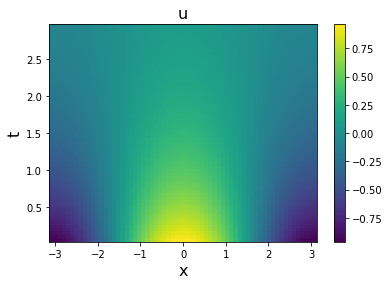

In [48]:
u_reduced = np.real(storage.data)[1:-1, :]

plot_solution(x, t[1:-1], u_reduced, "u")

In [49]:
u_r = u_reduced.reshape(len(t)-2, len(x), 1)
model2 = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model2.fit(u_r, t=dt)
model2.print()

(x0)' = -0.768 x0 + -2.087 x0_1
